In [ ]:
import math

import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyproj import Transformer
from scipy.stats import entropy
from shapely.geometry import Point

In [2]:
CITY = "helsinki"
VERSION = "20250428"

In [4]:
# define path for socioecon info
socioecon_path = f"../../output/{CITY}/gini.geojson"
# city boundary
helsinki_path = f"../../data/osm/{CITY}/boundary.geojson"

path = f"../../output/{CITY}/{VERSION}/"

# Read the GeoJSON file where for each stop id we know the multimodal area (5 min walk + 10 min BKK) + ellipticity of this shape + size of the area
# and multipolygons describing the 5 min walk from each such station
multimodal = gpd.read_file(
    f"{path}/stop_geometries_from_walk.geojson", engine="pyogrio"
)
# Read GeoJSON file for 15 minute walking distance
walking = gpd.read_file(f"{path}/isochrones.geojson", engine="pyogrio")
# read centrality csv
centrality = pd.read_csv(
    f"{path}/merged.csv",
    dtype={
        "stop_id": str,
    },
)

# Read the pickle file into a DataFrame
socioecon = gpd.read_file(socioecon_path, engine="pyogrio")
# read in geojson for city boundary
helsinki = gpd.read_file(helsinki_path, engine="pyogrio")

In [ ]:
# Pipeline

# 0. Filter walking to 15min walk
# 1. match hexagons & other small shapes to walking15 shapes and multimodal
# 2. Append to socioecon data
# 3. For multimodal, count average income, nr poor households/total households (poor household %) within area
# 4. For walking15 count within area
# 5. Calculate a) low income ratio b) Gini, c) income entropy -- however how? income level at each location? and characterise low/mid/high income for Gini?

### Filter walking

In [5]:
walking15 = walking[(walking["costing"] == "walk") & (walking["range"] == 15)]
walking15 = walking15.copy()
walking15.drop(columns=["costing", "range"], inplace=True)

In [6]:
stops = multimodal
hel_area = helsinki.geometry[0]
centrality["stop_id"] = centrality["stop_id"].astype(str)
stops["stop_id"] = stops["stop_id"].astype(str)
merged_df = stops.merge(centrality, on="stop_id", how="left")

# Convert to GeoDataFrame using lat/lon
merged_df["geometry"] = merged_df.apply(
    lambda row: Point(row["stop_lon"], row["stop_lat"]), axis=1
)
merged_gdf = gpd.GeoDataFrame(
    merged_df, geometry="geometry", crs="EPSG:4326"
)  # WGS84 lat/lon

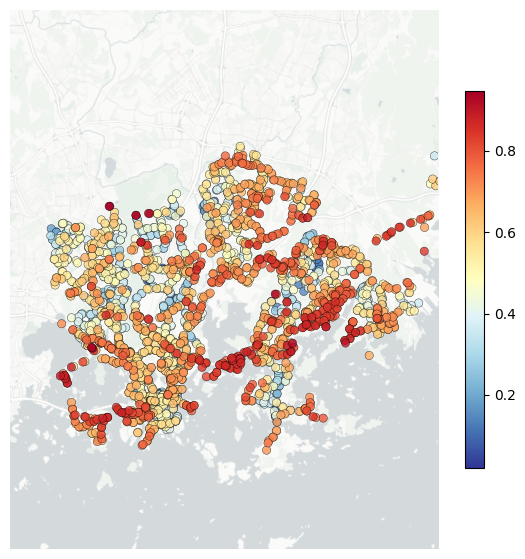

In [8]:
stops = multimodal
hel_area = helsinki.geometry[0]
centrality["stop_id"] = centrality["stop_id"].astype(str)
stops["stop_id"] = stops["stop_id"].astype(str)
merged_df = stops.merge(centrality, on="stop_id", how="left")

# Convert to GeoDataFrame using lat/lon
merged_df["geometry"] = merged_df.apply(
    lambda row: Point(row["stop_lon"], row["stop_lat"]), axis=1
)
merged_gdf = gpd.GeoDataFrame(
    merged_df, geometry="geometry", crs="EPSG:4326"
)  # WGS84 lat/lon

# Convert to Web Mercator (EPSG:3857) for basemap
merged_gdf = merged_gdf.to_crs(epsg=3857)

# Sort by ellipticity
to_plot_el = merged_gdf.sort_values("ellipticity_x", ascending=True)

# Define figure and axis
fig, ax = plt.subplots(figsize=(7, 7))

# Define Helsinki bounding box in EPSG:4326 (lat/lon)
helsinki_bbox = {
    "minx": 24.8,
    "maxx": 25.2,
    "miny": 60.1,
    "maxy": 60.35,
}

# Convert bounding box to Web Mercator (EPSG:3857)


transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)

minx, miny = transformer.transform(helsinki_bbox["minx"], helsinki_bbox["miny"])
maxx, maxy = transformer.transform(helsinki_bbox["maxx"], helsinki_bbox["maxy"])

# Set plot limits
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot base map outline (optional, assuming bp is another GeoDataFrame)
helsinki.plot(ax=ax, fc="none", ec="#2d2d2d")

# Clip to relevant area if needed
to_plot_clipped = (
    gpd.clip(to_plot_el, hel_area) if "bp_area" in locals() else to_plot_el
)

# Plot circle markers based on lat/lon with color by ellipticity
to_plot_clipped.plot(
    column="ellipticity_x",
    legend=True,
    legend_kwds={"shrink": 0.7},
    # markersize=minmax_scale(to_plot_clipped["ellipticity"], feature_range=(10, 100)),  # Adjust size range
    cmap="RdYlBu_r",
    ax=ax,
    alpha=0.8,
    edgecolor="black",
    linewidth=0.3,
)

# Add basemap
cx.add_basemap(
    ax,
    crs=merged_gdf.crs,
    source=cx.providers.CartoDB.PositronNoLabels,
    alpha=1,
    attribution=False,
)

# Remove axis
ax.axis("off")
ax.margins(0)


plt.show()

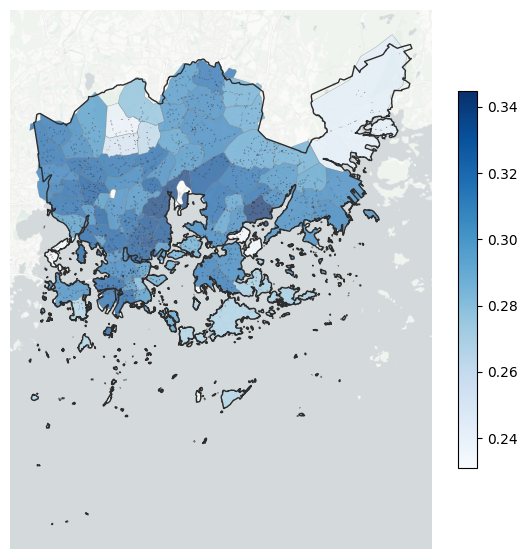

In [9]:
# Convert stop_id to string
stops = multimodal
hel_area = helsinki.geometry[0]
centrality["stop_id"] = centrality["stop_id"].astype(str)
stops["stop_id"] = stops["stop_id"].astype(str)

# Merge stops with centrality data
merged_df = stops.merge(
    centrality[["stop_id", "stop_lat", "stop_lon"]], on="stop_id", how="left"
)

# Convert to GeoDataFrame using lat/lon
merged_df["geometry"] = merged_df.apply(
    lambda row: Point(row["stop_lon"], row["stop_lat"]), axis=1
)
merged_gdf = gpd.GeoDataFrame(
    merged_df, geometry="geometry", crs="EPSG:4326"
)  # WGS84 lat/lon

# Ensure socioecon is in the correct CRS (Web Mercator for contextily)
socioecon2 = socioecon.to_crs(epsg=3857)

# Sort by ellipticity
to_plot_el = merged_gdf.sort_values("ellipticity", ascending=True)

# Convert bounding box to Web Mercator (EPSG:3857)
helsinki_bbox = {
    "minx": 24.8,
    "maxx": 25.2,
    "miny": 60.1,
    "maxy": 60.35,
}

transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
minx, miny = transformer.transform(helsinki_bbox["minx"], helsinki_bbox["miny"])
maxx, maxy = transformer.transform(helsinki_bbox["maxx"], helsinki_bbox["maxy"])

# Convert merged_gdf to EPSG:3857 before plotting with contextily
merged_gdf = merged_gdf.to_crs(epsg=3857)

# Define figure and axis
fig, ax = plt.subplots(figsize=(7, 7))

# Plot socioecon layer
socioecon2.plot(
    ax=ax,
    column="gini",  # Replace with the relevant socio-economic column
    cmap="Blues",
    alpha=0.7,
    edgecolor="gray",
    linewidth=0.3,
    legend=True,
    legend_kwds={"shrink": 0.7},
)

# Plot Helsinki boundary
helsinki.to_crs(epsg=3857).plot(ax=ax, fc="none", ec="#2d2d2d")

# Clip to relevant area if needed
to_plot_clipped = (
    gpd.clip(to_plot_el, hel_area) if "bp_area" in locals() else to_plot_el
)
to_plot_clipped = to_plot_clipped.to_crs(epsg=3857)  # Convert clipped data to EPSG:3857

# Ensure valid geometries before plotting
to_plot_clipped = to_plot_clipped[to_plot_clipped.geometry.notnull()]

# Plot stop markers with color based on ellipticity
to_plot_clipped.plot(
    column="ellipticity",
    legend=False,
    cmap="RdYlBu_r",
    ax=ax,
    alpha=0.3,
    edgecolor="black",
    linewidth=0.3,
    markersize=0.2,
)

# Add basemap (Ensure CRS is EPSG:3857)
cx.add_basemap(
    ax,
    crs="EPSG:3857",
    source=cx.providers.CartoDB.PositronNoLabels,
    alpha=1,
    attribution=False,
    zoom=12,  # Set zoom level to prevent errors
)

# Remove axis
ax.axis("off")
ax.margins(0)

plt.show()

### Match tract shapes to walking and multimodal areas

In [10]:
def add_tract_ids(geo_df, tract_df):
    """
    Adds a column of census tract IDs to a GeoDataFrame based on spatial intersection.

    Parameters:
    geo_df (GeoDataFrame): The input GeoDataFrame with geometries representing walking/multimodal areas.
    socioecon_df (GeoDataFrame): The GeoDataFrame with census tract geometries and tract codes.

    Returns:
    GeoDataFrame: The updated GeoDataFrame with a new column 'tract_code' containing the matched tract codes.
    """

    # Ensure both GeoDataFrames have the same CRS
    if geo_df.crs != tract_df.crs:
        geo_df = geo_df.to_crs(tract_df.crs)

    # Perform spatial join to assign census tract IDs to walking geometries
    geo_tracts = gpd.sjoin(
        geo_df,
        tract_df[["postal_code", "geometry"]],
        how="left",
        predicate="intersects",
    )

    return geo_tracts

In [11]:
walking15_tract = add_tract_ids(walking15, socioecon)

In [12]:
multimodal_tract = add_tract_ids(multimodal, socioecon)

/tmp/ipykernel_67456/2234721604.py:31: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
/tmp/ipykernel_67456/2234721604.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


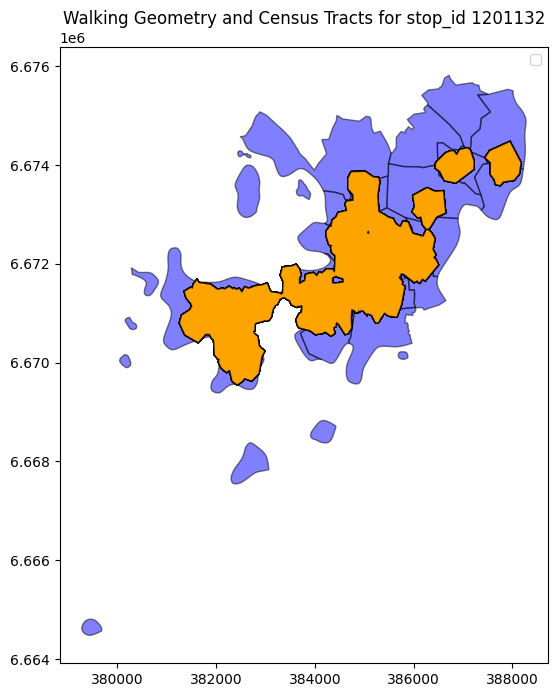

In [14]:
# Choose a stop_id to visualize
stop_id_to_plot = multimodal_tract.iloc[150].stop_id

# Get all walking geometries for this stop_id
walking_geoms = multimodal_tract[
    multimodal_tract["stop_id"] == stop_id_to_plot
].geometry

# Get all census tracts that overlap with this stop_id
tract_codes = multimodal_tract[multimodal_tract["stop_id"] == stop_id_to_plot][
    "postal_code"
].unique()
tract_geoms = socioecon[
    socioecon["postal_code"].isin(tract_codes)
]  # Get all matching tracts

# Plot both layers on top of each other
fig, ax = plt.subplots(figsize=(8, 8))

# Plot all census tracts associated with the stop_id
tract_geoms.plot(
    ax=ax, color="blue", edgecolor="black", alpha=0.5, label="Census Tracts"
)

# Plot all walking geometries for this stop_id
gpd.GeoSeries(walking_geoms).plot(
    ax=ax, color="orange", edgecolor="black", alpha=0.7, label="Walking Geometry"
)

ax.set_title(f"Walking Geometry and Census Tracts for stop_id {stop_id_to_plot}")
plt.legend()
plt.show()

### # 2. Append to socioecon data

In [15]:
def compute_weighted_stat(geo_tract, socioecon, stat_column, tract_col):
    """
    Computes the weighted average of a specified column (e.g., income or Gini) for each stop_id.

    Parameters:
    geo_tract (GeoDataFrame): Contains stop_id and the corresponding census tract codes.
    socioecon (GeoDataFrame): Contains census tract geometries and the specified statistical column (income, gini etc).
    stat_column (str): The column name in socioecon to be weighted (e.g., 'net_income_hh' or 'gini').

    Returns:
    DataFrame: df with stop_id and the weighted average of the specified column.
    """

    # Merge to include the  statistic and tract geometries
    merged = geo_tract.merge(
        socioecon[[tract_col, "geometry", stat_column]], on=tract_col, how="left"
    )

    # Rename columns
    merged = merged.rename(
        columns={"geometry_x": "stop_geometry", "geometry_y": "tract_geometry"}
    )

    # Set the stop area geometry as the active geometry
    merged = merged.set_geometry("stop_geometry")

    # Ensure both datasets have the same CRS
    if merged.crs != socioecon.crs:
        merged = merged.to_crs(socioecon.crs)

    # Compute intersection area
    merged["intersection"] = merged.apply(
        lambda row: row.stop_geometry.intersection(row.tract_geometry), axis=1
    )
    merged["intersection_area"] = merged["intersection"].area
    merged["tract_area"] = merged["tract_geometry"].area

    # Compute weights: % of tract within stop area
    merged["weight"] = merged["intersection_area"] / merged["tract_area"]

    # Compute weighted statistic for each row
    merged["weighted_stat"] = merged["weight"] * merged[stat_column]

    # Compute weighted average per stop_id
    result = (
        merged.groupby("stop_id")
        .apply(
            lambda g: pd.Series(
                {
                    f"weighted_{stat_column}": g["weighted_stat"].sum()
                    / g["weight"].sum()
                }
            )
        )
        .reset_index()
    )

    return result

In [16]:
# Compute weighted gini
multimodal_weighted_gini_per_stop = compute_weighted_stat(
    multimodal_tract, socioecon, "gini", "postal_code"
)
# merge with walking shape
multimodal_weighted_gini = multimodal_weighted_gini_per_stop.merge(
    multimodal[["stop_id", "geometry"]], on="stop_id"
)
# Convert result into a GeoDataFrame
multimodal_weighted_gini_gpd = gpd.GeoDataFrame(
    multimodal_weighted_gini, geometry="geometry", crs=multimodal_tract.crs
)

/tmp/ipykernel_67456/3607863481.py:47: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


In [17]:
# Compute weighted gini
walk_weighted_gini_per_stop = compute_weighted_stat(
    walking15_tract, socioecon, "gini", "postal_code"
)
# merge with walking shape
walk_weighted_gini = walk_weighted_gini_per_stop.merge(
    walking15[["stop_id", "geometry"]], on="stop_id"
)
# Convert result into a GeoDataFrame
walk_weighted_gini_gpd = gpd.GeoDataFrame(
    walk_weighted_gini, geometry="geometry", crs=multimodal_tract.crs
)

/tmp/ipykernel_67456/3607863481.py:47: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


In [18]:
# Compute weighted net income
multimodal_weighted_income_per_stop = compute_weighted_stat(
    multimodal_tract, socioecon, "med_inc", "postal_code"
)
# merge with multimodal shape
multimodal_weighted_income = multimodal_weighted_income_per_stop.merge(
    multimodal[["stop_id", "geometry"]], on="stop_id"
)
# Convert result into a GeoDataFrame
multimodal_weighted_income_gpd = gpd.GeoDataFrame(
    multimodal_weighted_income, geometry="geometry", crs=multimodal_tract.crs
)

/tmp/ipykernel_67456/3607863481.py:47: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


In [19]:
# Compute weighted net income
walk_weighted_income_per_stop = compute_weighted_stat(
    walking15_tract, socioecon, "med_inc", "postal_code"
)
# merge with walk shape
walk_weighted_income = walk_weighted_income_per_stop.merge(
    walking15[["stop_id", "geometry"]], on="stop_id"
)
# Convert result into a GeoDataFrame
walk_weighted_income_gpd = gpd.GeoDataFrame(
    walk_weighted_income, geometry="geometry", crs=multimodal_tract.crs
)

/tmp/ipykernel_67456/3607863481.py:47: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


In [20]:
# Compute weighted nr of 3 income categories for multimodal:
# low income
multimodal_weighted_low_income_per_stop = compute_weighted_stat(
    multimodal_tract, socioecon, "hh_low", "postal_code"
)
# merge with multi shape
multimodal_weighted_low_income = multimodal_weighted_low_income_per_stop.merge(
    multimodal[["stop_id", "geometry"]], on="stop_id"
)

# mid income
multimodal_weighted_mid_income_per_stop = compute_weighted_stat(
    multimodal_tract, socioecon, "hh_mid", "postal_code"
)
# merge with multi shape
multimodal_weighted_mid_income = multimodal_weighted_mid_income_per_stop.merge(
    multimodal[["stop_id", "geometry"]], on="stop_id"
)

# high income
multimodal_weighted_high_income_per_stop = compute_weighted_stat(
    multimodal_tract, socioecon, "hh_high", "postal_code"
)
# merge with multi shape
multimodal_weighted_high_income = multimodal_weighted_high_income_per_stop.merge(
    multimodal[["stop_id", "geometry"]], on="stop_id"
)

/tmp/ipykernel_67456/3607863481.py:47: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(
/tmp/ipykernel_67456/3607863481.py:47: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(
/tmp/ipykernel_67456/3607863481.py:47: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from th

In [21]:
# merge them into 3 for entropy calculation

low = multimodal_weighted_low_income[["stop_id", "weighted_hh_low"]].copy()
mid = multimodal_weighted_mid_income[["stop_id", "weighted_hh_mid"]].copy()
high = multimodal_weighted_high_income[["stop_id", "weighted_hh_high"]].copy()

# Merge all three on stop_id
multimodal_income = low.merge(mid, on="stop_id", how="outer").merge(
    high, on="stop_id", how="outer"
)

In [22]:
# Compute weighted nr of 3 income categories for walking:
# low income
walk_weighted_low_income_per_stop = compute_weighted_stat(
    walking15_tract, socioecon, "hh_low", "postal_code"
)
# merge with walk shape
walk_weighted_low_income = walk_weighted_low_income_per_stop.merge(
    walking15[["stop_id", "geometry"]], on="stop_id"
)

# mid income
walk_weighted_mid_income_per_stop = compute_weighted_stat(
    walking15_tract, socioecon, "hh_mid", "postal_code"
)
# merge with walk shape
walk_weighted_mid_income = walk_weighted_mid_income_per_stop.merge(
    walking15[["stop_id", "geometry"]], on="stop_id"
)

# high income
walk_weighted_high_income_per_stop = compute_weighted_stat(
    walking15_tract, socioecon, "hh_high", "postal_code"
)
# merge with walk shape
walk_weighted_high_income = walk_weighted_high_income_per_stop.merge(
    walking15[["stop_id", "geometry"]], on="stop_id"
)

/tmp/ipykernel_67456/3607863481.py:47: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(
/tmp/ipykernel_67456/3607863481.py:47: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(
/tmp/ipykernel_67456/3607863481.py:47: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from th

In [23]:
# merge them into 3 for entropy calculation

low2 = walk_weighted_low_income[["stop_id", "weighted_hh_low"]].copy()
mid2 = walk_weighted_mid_income[["stop_id", "weighted_hh_mid"]].copy()
high2 = walk_weighted_high_income[["stop_id", "weighted_hh_high"]].copy()

# Merge all three on stop_id
walk_income = low2.merge(mid2, on="stop_id", how="outer").merge(
    high2, on="stop_id", how="outer"
)

In [24]:
# Merge the two dataframes on stop_id
gini_change = multimodal_weighted_gini.merge(
    walk_weighted_gini_per_stop[["stop_id", "weighted_gini"]],
    on="stop_id",
    suffixes=("_multi", "_walk"),
    how="left",
)

# Calculate percentage change
gini_change["percent_change_gini"] = (
    (gini_change["weighted_gini_multi"] - gini_change["weighted_gini_walk"])
    / gini_change["weighted_gini_walk"]
) * 100

# NA values if either input is NA
gini_change["percent_change_gini"] = gini_change["percent_change_gini"].where(
    gini_change[["weighted_gini_multi", "weighted_gini_walk"]].notna().all(axis=1)
)

# Calculate log change
gini_change["log_change_gini"] = np.log(
    gini_change["weighted_gini_multi"] / gini_change["weighted_gini_walk"]
)

gini_change_gpd = gpd.GeoDataFrame(
    gini_change, geometry="geometry", crs=multimodal_tract.crs
)

In [25]:
# Merge the two dataframes on stop_id
income_change = multimodal_weighted_income.merge(
    walk_weighted_income_per_stop[["stop_id", "weighted_med_inc"]],
    on="stop_id",
    suffixes=("_multi", "_walk"),
    how="left",
)

# Calculate percentage change
income_change["percent_change_income"] = (
    (income_change["weighted_med_inc_multi"] - income_change["weighted_med_inc_walk"])
    / income_change["weighted_med_inc_walk"]
) * 100

# NA values if either input is NA
income_change["percent_change_income"] = income_change["percent_change_income"].where(
    income_change[["weighted_med_inc_multi", "weighted_med_inc_walk"]]
    .notna()
    .all(axis=1)
)

# Calculate log change
income_change["log_change_income"] = np.log(
    income_change["weighted_med_inc_multi"] / income_change["weighted_med_inc_walk"]
)

income_change_gpd = gpd.GeoDataFrame(
    income_change, geometry="geometry", crs=multimodal_tract.crs
)

### Calculate entropy

In [27]:
def entropy(arr, n):
    rel_freq = list([i / sum(arr) for i in arr])
    entropy = sum((-f * math.log2(f)) for f in rel_freq if f > 0)
    #     print(arr, entropy)
    return entropy


# possibility to normalize entropy
# entropy = sum((-f*math.log2(f))/math.log2(n) for f in rel_freq if f>0)

In [28]:
multimodal_income2 = multimodal_income.drop(columns=["stop_id"])
multimodal_income["entropy"] = multimodal_income2.apply(
    lambda row: entropy(row.values, 3), axis=1
)

In [29]:
walk_income2 = walk_income.drop(columns=["stop_id"])
walk_income["entropy"] = walk_income2.apply(lambda row: entropy(row.values, 3), axis=1)

In [30]:
# Merge the two dataframes on stop_id
entropy_change = multimodal_income.merge(
    walk_income, on="stop_id", suffixes=("_multi", "_walk"), how="left"
)

# Calculate percentage change
entropy_change["percent_change_entropy"] = (
    (entropy_change["entropy_multi"] - entropy_change["entropy_walk"])
    / entropy_change["entropy_walk"]
) * 100

# NA values if either input is NA
entropy_change["percent_change_entropy"] = entropy_change[
    "percent_change_entropy"
].where(entropy_change[["entropy_multi", "entropy_walk"]].notna().all(axis=1))

# Calculate log change
entropy_change["log_change_entropy"] = np.log(
    entropy_change["entropy_multi"] / entropy_change["entropy_walk"]
)

In [31]:
stop_income_gini = income_change.merge(
    gini_change[
        [
            "stop_id",
            "weighted_gini_multi",
            "weighted_gini_walk",
            "percent_change_gini",
            "log_change_gini",
        ]
    ],
    on="stop_id",
    how="left",
)
# stop_income_gini.to_csv('/mnt/common-ssd/zadorzsofi/telekom/BKK/data/socioecon_change/helsinki_socioecon_change.csv', index= False)

In [32]:
stop_income_gini2 = stop_income_gini.drop(columns=["geometry"])
inc_gini_entr = stop_income_gini2.merge(entropy_change, on="stop_id", how="left")

In [35]:
stop_merged = inc_gini_entr.merge(centrality, on="stop_id", how="left")
stop_merged.to_csv(
    f"../../output/{CITY}/socioecon_merged4.csv",
    index=False,
)

In [33]:
inc_gini_entr.head()

,stop_id,weighted_med_inc_multi,weighted_med_inc_walk,percent_change_income,log_change_income,weighted_gini_multi,weighted_gini_walk,percent_change_gini,log_change_gini,weighted_hh_low_multi,weighted_hh_mid_multi,weighted_hh_high_multi,entropy_multi,weighted_hh_low_walk,weighted_hh_mid_walk,weighted_hh_high_walk,entropy_walk,percent_change_entropy,log_change_entropy
0,1010102,49133.699590,51163.721205,-3.967697,-0.040486,0.302761,0.297902,1.631070,0.016179,747.071981,1771.924429,1725.386398,1.495160,529.041739,1328.328827,1418.629864,1.475719,1.317426,0.013088
1,1010103,46938.055693,50411.739647,-6.890625,-0.071395,0.306655,0.299884,2.257847,0.022327,959.482438,2171.957787,1560.384122,1.510861,657.954063,1606.136413,1543.333265,1.491043,1.329159,0.013204
2,1010105,44797.560662,49264.567300,-9.067382,-0.095051,0.310454,0.302707,2.559054,0.025269,1176.074691,2518.697397,1663.131577,1.516022,814.850234,1948.988527,1699.137254,1.500341,1.045196,0.010398
3,1010106,48715.493718,48795.504483,-0.163972,-0.001641,0.303187,0.303852,-0.218808,-0.002190,817.266033,1906.136779,1664.138420,1.504634,880.570755,2090.690387,1775.515640,1.502564,0.137760,0.001377
4,1010107,45393.697990,47426.970665,-4.287165,-0.043818,0.311226,0.307072,1.352703,0.013436,1022.242307,2239.258885,1510.855829,1.513714,1075.765547,2504.159503,1992.517612,1.507207,0.431690,0.004308


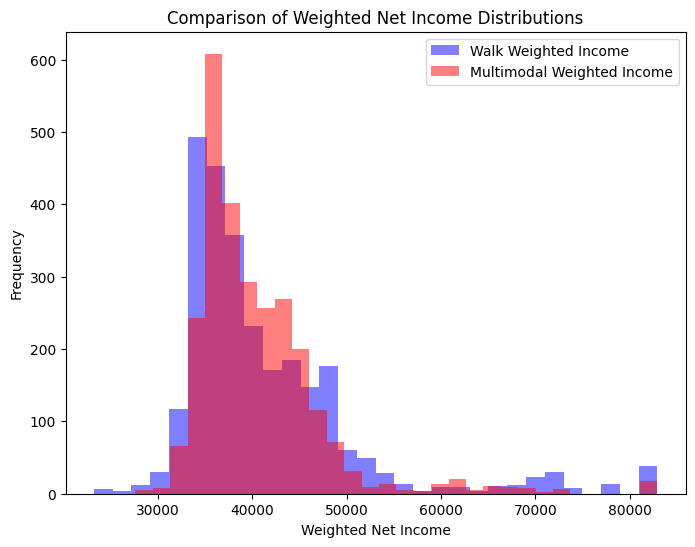

In [34]:
# Plot histograms
plt.figure(figsize=(8, 6))
plt.hist(
    walk_weighted_income_per_stop.weighted_med_inc,
    bins=30,
    alpha=0.5,
    color="blue",
    label="Walk Weighted Income",
)
plt.hist(
    multimodal_weighted_income_per_stop.weighted_med_inc,
    bins=30,
    alpha=0.5,
    color="red",
    label="Multimodal Weighted Income",
)

# Labels and title
plt.xlabel("Weighted Net Income")
plt.ylabel("Frequency")
plt.title("Comparison of Weighted Net Income Distributions")
plt.legend()

# Show plot
plt.show()